In [149]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [150]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits
import glob
import pandas as pd
import xarray as xr
import cartopy
from cartopy.util import add_cyclic_point
import cartopy.crs as ccrs
import scipy.stats
import scipy as sp
from scipy import signal
import os
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

In [151]:
# first load your data

dirn = '/global/scratch/medhap02/ISMData/'
filen = 'GHCN_monthyv4p01.nc'
datgpcp = xr.open_mfdataset(dirn+filen,combine='by_coords')
# precip units are mm/day:
prgpcp = datgpcp['precip']

# select years of interest (dataset only goes thru march 2019):
prgpcp = prgpcp.sel(time=slice('1900-01-01','2014-12-31'))

In [152]:
# take summer mean:
def is_summer(month):
    return (month >= 6) & (month <= 9)
prgpcpSeas = prgpcp.sel(time=is_summer(prgpcp['time.month']))#.groupby('time.year').mean())

prgpcpSeas = prgpcpSeas.groupby('time.year',restore_coord_dims = True).mean("time")
print(prgpcpSeas.dims)

# rechunk data for efficiency:
prgpcpSeas.data = prgpcpSeas.data.rechunk(-1)

# eliminate any NaNs:
prgpcpSeas = prgpcpSeas.ffill('lon').bfill('lon').ffill('lat').bfill('lat')
prgpcpSeas.load()

('year', 'lat', 'lon')


/global/home/users/medhap02/.conda/envs/xarrayenv2/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'precip' (year: 115, lat: 360, lon: 720)>
array([[[2.1325, 2.1325, ..., 2.0975, 2.0975],
        [2.1325, 2.1325, ..., 2.0975, 2.0975],
        ...,
        [1.285 , 1.285 , ..., 1.2825, 1.2825],
        [1.29  , 1.29  , ..., 1.2925, 1.29  ]],

       [[2.09  , 2.09  , ..., 2.0075, 2.0075],
        [2.09  , 2.09  , ..., 2.0075, 2.0075],
        ...,
        [0.33  , 0.33  , ..., 0.33  , 0.33  ],
        [0.33  , 0.33  , ..., 0.33  , 0.33  ]],

       ...,

       [[2.2275, 2.2275, ..., 3.6   , 3.6   ],
        [2.2275, 2.2275, ..., 3.6   , 3.6   ],
        ...,
        [0.    , 0.    , ..., 0.    , 0.    ],
        [0.    , 0.    , ..., 0.    , 0.    ]],

       [[1.18  , 1.18  , ..., 1.73  , 1.73  ],
        [1.18  , 1.18  , ..., 1.73  , 1.73  ],
        ...,
        [0.    , 0.    , ..., 0.    , 0.    ],
        [0.    , 0.    , ..., 0.    , 0.    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon    

In [153]:
latlim1 = 90
latlim2 = -90

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_prfull = Eof(tmppr,weights=coslat2,center=True)
pcs_prfull = solver_prfull.pcs()
eofs_prfull = solver_prfull.eofs()
varfrac_prfull = solver_prfull.varianceFraction()

In [154]:
print(coslat2)
print(tmppr)

<xarray.DataArray 'lat' (year: 115, lat: 360, lon: 720)>
array([[[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.004363]],

       [[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.004363]],

       ...,

       [[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.004363]],

       [[0.004363, 0.004363, ..., 0.004363, 0.004363],
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        ...,
        [0.01309 , 0.01309 , ..., 0.01309 , 0.01309 ],
        [0.004363, 0.004363, ..., 0.004363, 0.0

In [155]:
#(5-35n, 65-95e)
latlim1 = 35
latlim2 = 5
lonlim1 = 65
lonlim2 = 95

# take seasonal mean and select latitudes to use in analysis:
tmppr = prgpcpSeas.sel(lat=slice(latlim1,latlim2), lon=slice(lonlim1,lonlim2))
# subtract time mean from each data point (EOFs work with anomalies)
tmppr = tmppr - tmppr.mean(dim='year')

# need to mark dimension along which we want to take EOFs:
#tmppr = tmppr.assign_coords(year=tmppr.year)
tmppr.year.attrs['axis'] = 'T'

# weight variables by the area of the lat-lon grid cell (which is proportional to cosine of latitude):
coslat = np.cos(tmppr.lat*np.pi/180)
tmppr2, coslat2 = xr.broadcast(tmppr, coslat)

# find the EOFs
solver_pr = Eof(tmppr,weights=coslat2,center=True)
pcs_pr = solver_pr.pcs()
eofs_pr = solver_pr.eofs()
varfrac_pr = solver_pr.varianceFraction()

In [156]:
tmpprtrimmed = tmppr.sel(year=slice('1979-01-01','2015-12-31'))
tmppr2, coslat2 = xr.broadcast(tmpprtrimmed, coslat)

solver_pr_trimmed = Eof(tmpprtrimmed,weights=coslat2,center=True)
pcs_pr_trimmed = solver_pr_trimmed.pcs()
eofs_pr_trimmed = solver_pr_trimmed.eofs()
varfrac_pr_trimmed = solver_pr_trimmed.varianceFraction()

# plot results

sum of variance in first 4 pr EOFs =  0.2746374
total anomaly variance pr = 1811341.4


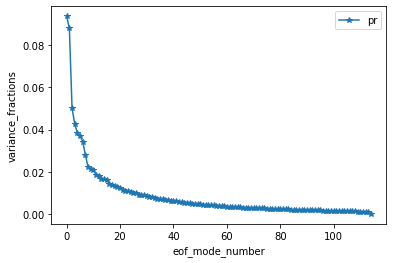

In [157]:
varfrac_prfull.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_prfull[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_prfull.totalAnomalyVariance())

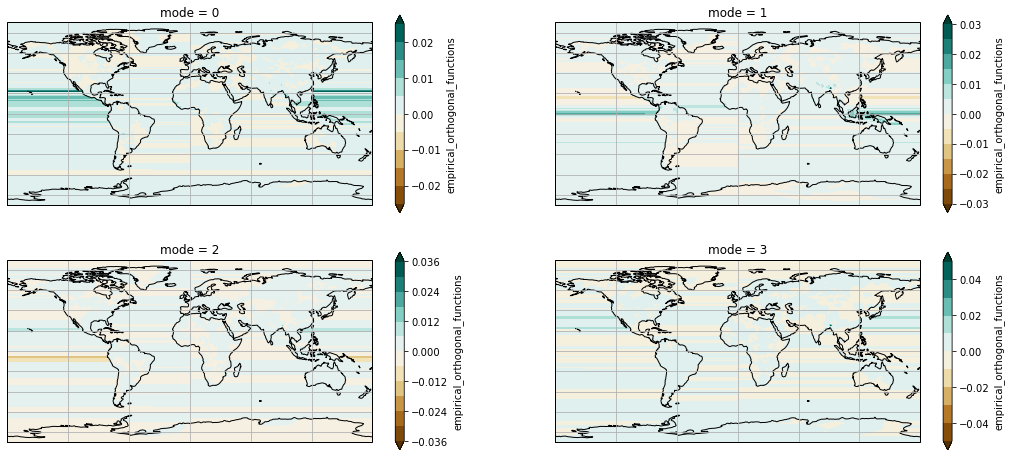

In [158]:
plt.figure(figsize=(18,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_prfull[i,:,:].plot.contourf(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([-180,180,-90,90],crs=ccrs.PlateCarree())

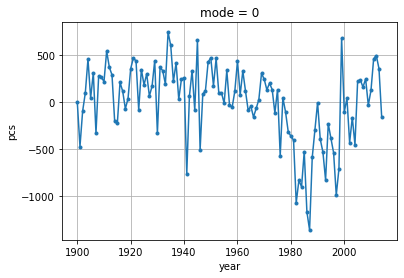

In [159]:
pcs_prfull.sel(mode=0).plot(marker='.')
plt.grid()

sum of variance in first 4 pr EOFs =  0.37279665
total anomaly variance pr = 67110.336


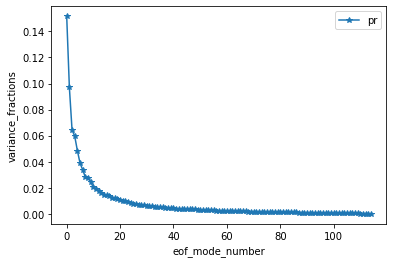

In [160]:
varfrac_pr.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr.totalAnomalyVariance())

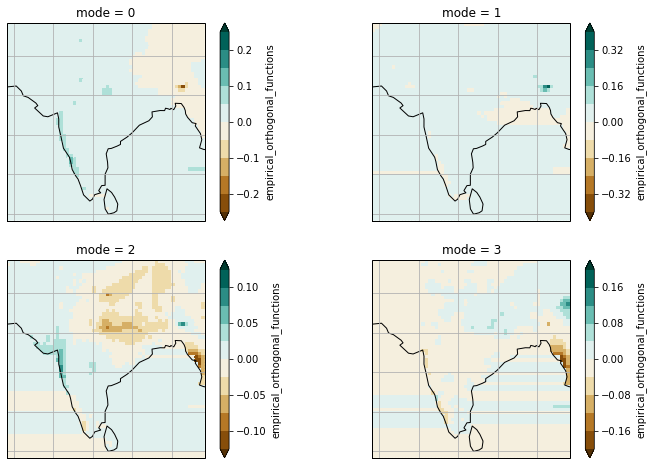

In [181]:
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

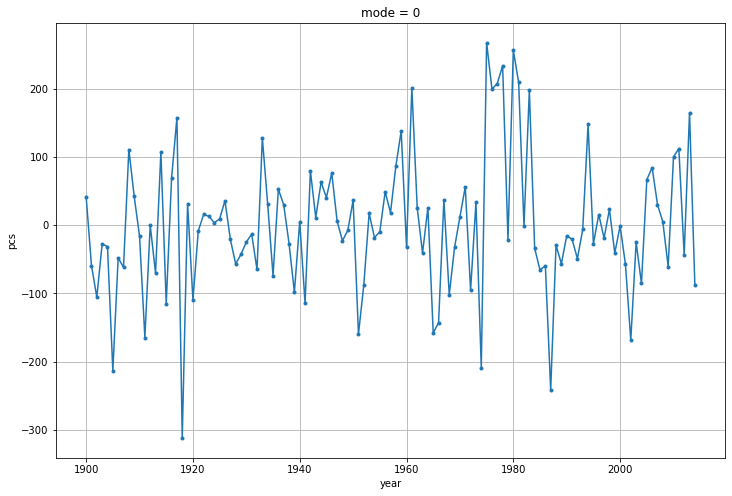

In [221]:
levels=np.linspace(-90, 90, 13)
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=0).plot(marker='.')
plt.grid()

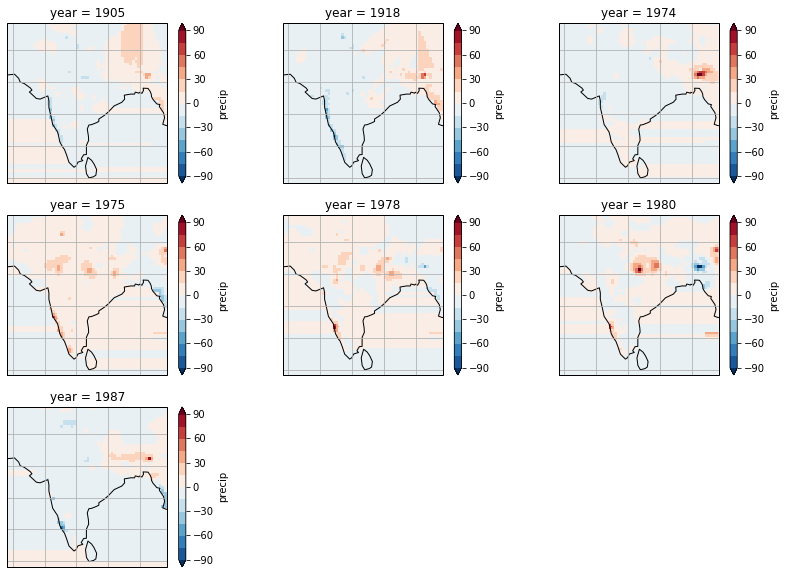

In [224]:
pcs_pr.sel(mode=0)
mode0 = [5, 18, 74, 75, 78, 80, 87]
plt.figure(figsize=(14,10))
for i in np.arange(0,7):
    ax = plt.subplot(3,3,i+1,projection=ccrs.PlateCarree());
    tmppr[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

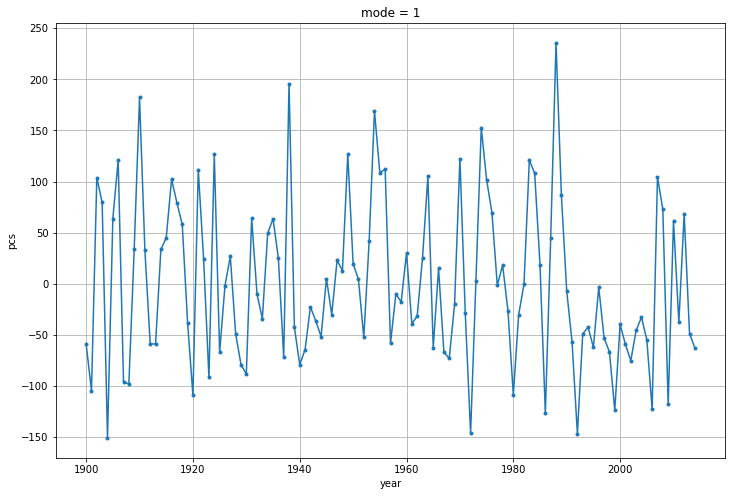

In [164]:
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=1).plot(marker='.')
plt.grid()

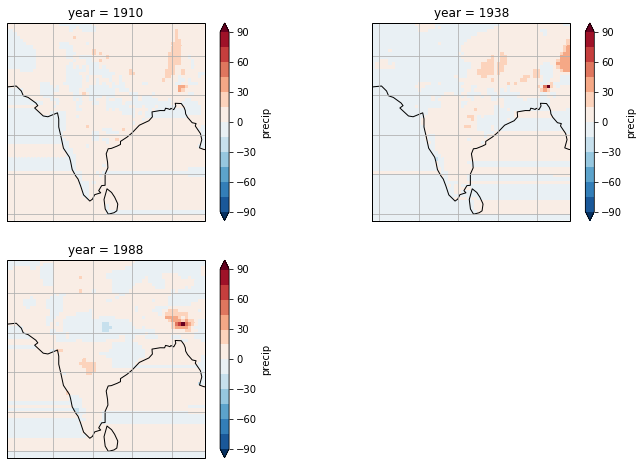

In [225]:
pcs_pr.sel(mode=1)
mode1 = [10, 38, 88]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode1[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

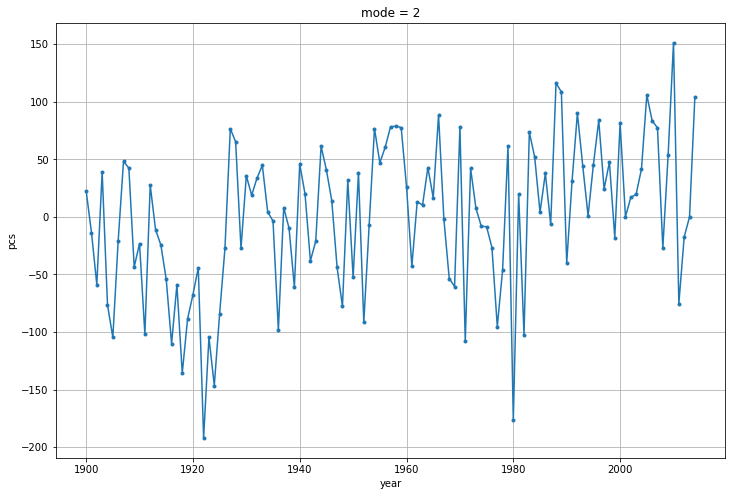

In [166]:
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=2).plot(marker='.')
plt.grid()

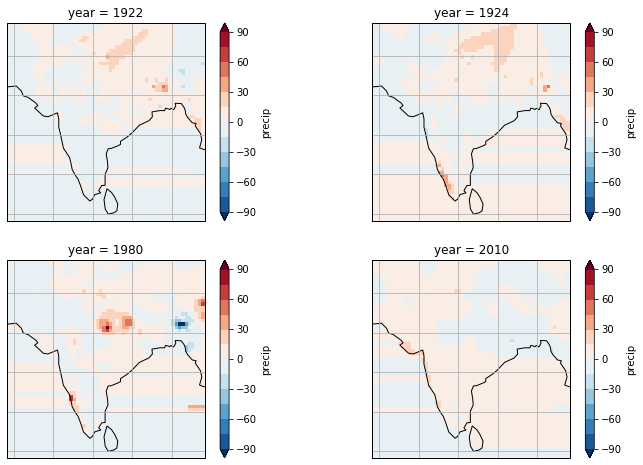

In [226]:
pcs_pr.sel(mode=2)
mode2 = [22, 24, 80, 110]
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmppr[mode2[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

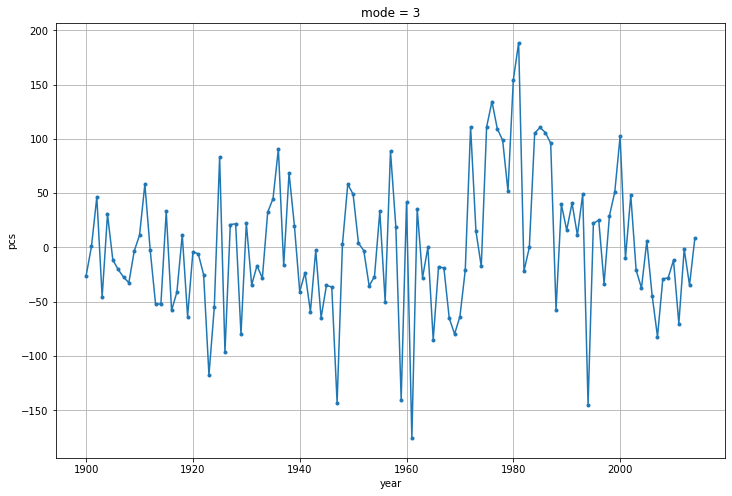

In [168]:
plt.figure(figsize=(12,8))
pcs_pr.sel(mode=3).plot(marker='.')
plt.grid()

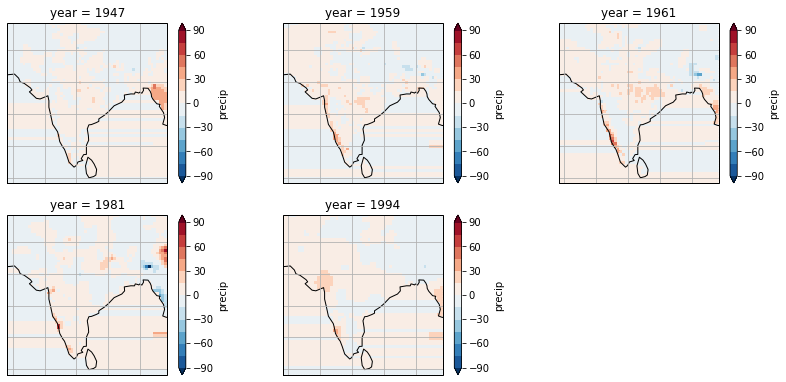

In [227]:
pcs_pr.sel(mode=0)
mode0 = [47, 59, 61, 81, 94]
plt.figure(figsize=(14,10))
for i in np.arange(0,5):
    ax = plt.subplot(3,3,i+1,projection=ccrs.PlateCarree());
    tmppr[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

sum of variance in first 4 pr EOFs =  0.5481825
total anomaly variance pr = 61908.96


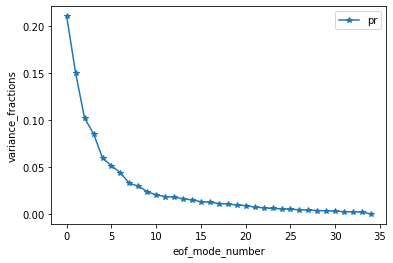

In [170]:
varfrac_pr_trimmed.plot(marker='*',label='pr')
print('sum of variance in first 4 pr EOFs = ', varfrac_pr_trimmed[0:4].sum().data)
plt.legend()
print('total anomaly variance pr =', solver_pr_trimmed.totalAnomalyVariance())

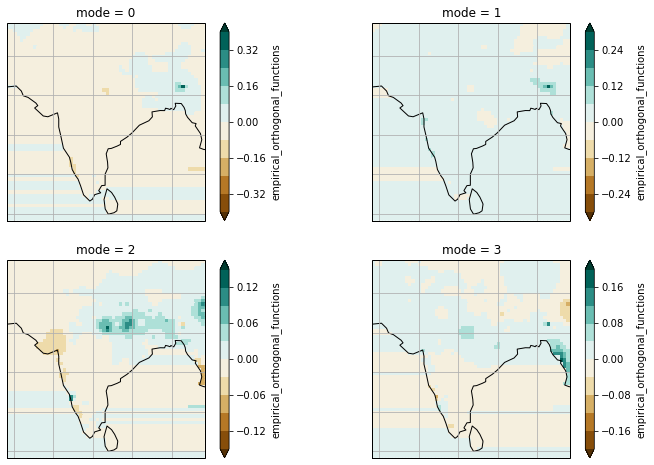

In [174]:
plt.figure(figsize=(12,8))
for i in np.arange(0,4):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    eofs_pr_trimmed[i,:,:].plot.pcolormesh(ax=ax,levels=12,extend='both',cmap=cm.BrBG)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

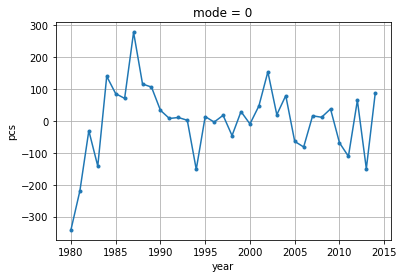

In [213]:
levels=np.linspace(-90, 90, 13)
pcs_pr_trimmed.sel(mode=0).plot(marker='.')
plt.grid()

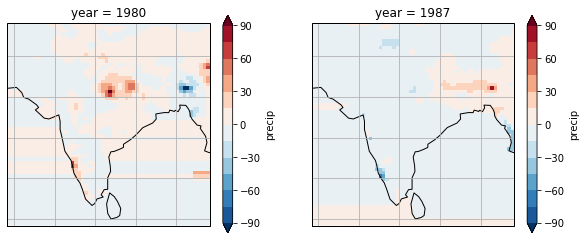

In [214]:
pcs_pr.sel(mode=0)
mode0 = [0, 7]
plt.figure(figsize=(10,4))
for i in np.arange(0,2):
    ax = plt.subplot(1,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode0[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

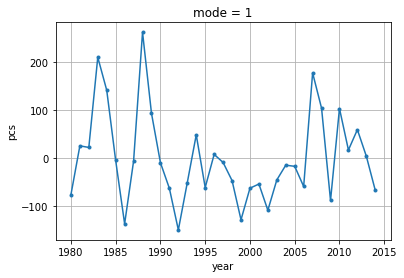

In [215]:
pcs_pr_trimmed.sel(mode=1).plot(marker='.')
plt.grid()

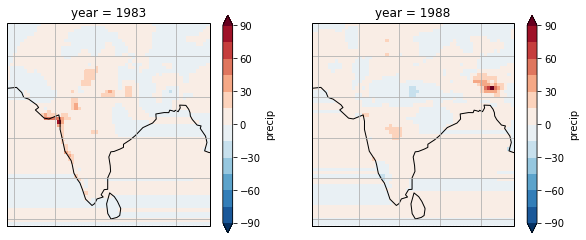

In [216]:
pcs_pr.sel(mode=1)
mode1 = [3, 8]
plt.figure(figsize=(10,4))
for i in np.arange(0,2):
    ax = plt.subplot(1,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode1[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

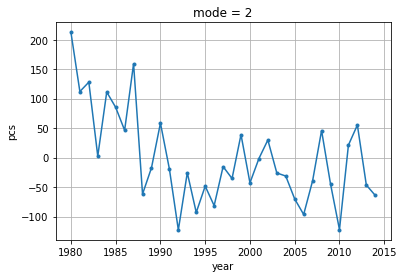

In [217]:
pcs_pr_trimmed.sel(mode=2).plot(marker='.')
plt.grid()

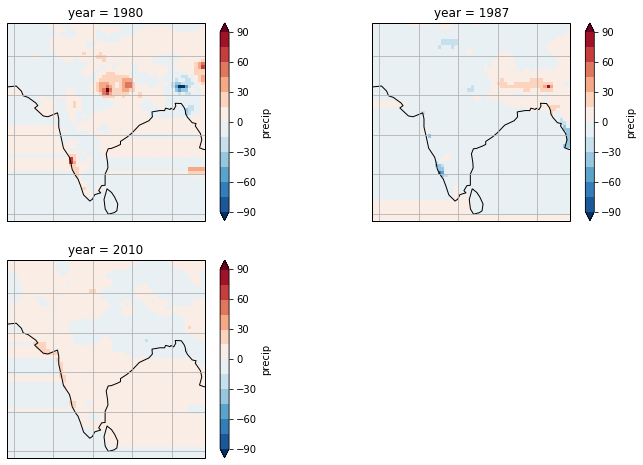

In [218]:
pcs_pr.sel(mode=2)
mode2 = [0, 7, 30]
plt.figure(figsize=(12,8))
for i in np.arange(0,3):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode2[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

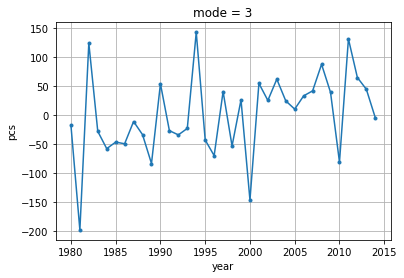

In [219]:
pcs_pr_trimmed.sel(mode=3).plot(marker='.')
plt.grid()

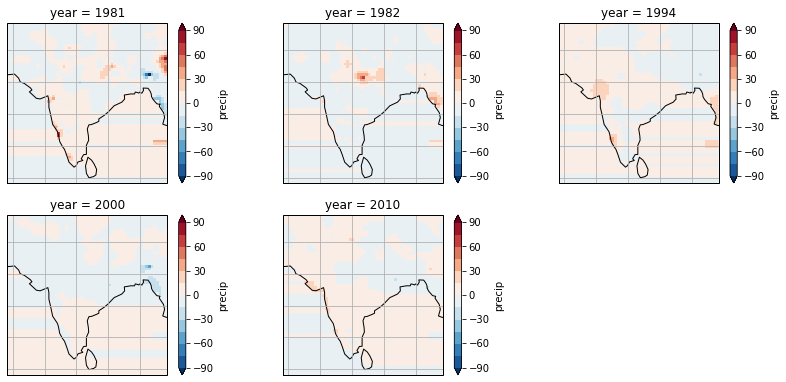

In [220]:
pcs_pr.sel(mode=3)
mode3 = [1, 2, 14, 20, 30]
plt.figure(figsize=(14,10))
for i in np.arange(0,5):
    ax = plt.subplot(3,3,i+1,projection=ccrs.PlateCarree());
    tmpprtrimmed[mode3[i],:,:].plot.pcolormesh(ax=ax,levels=levels,extend='both')
    ax.coastlines()
    gl = ax.gridlines(draw_labels=False)
    ax.set_extent([65,95,5,35],crs=ccrs.PlateCarree())

In [173]:
 # Copyright (c) 2020 Medha Palavalli.